In [1]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
from scipy import stats

### Read in dirty data from json files

In [2]:
past30Days1 = pd.read_json('oldTweetsOfSample.json',lines=True)
mostRecent1 = pd.read_json('recentTweets.json',lines=True)
past30Days2 = pd.read_json('MoreOldTweetsOfSample.json',lines=True)
mostRecent2 = pd.read_json('moreRecentTweets.json',lines=True)

In [3]:
df = pd.concat([past30Days1,mostRecent1,past30Days2,mostRecent2],ignore_index=True)

In [4]:
print(len(df))

27262


So we've gathered almost 30,000 tweets from 600 users.

# Feature Extraction

In [5]:
print(len(df.place.value_counts()))

30


Since only a few of our individuals have locations or places tagged, there is't suffecient to do any analysis. Thus, we omit them

In [6]:
drop_cols = ['id','id_str','truncated','in_reply_to_status_id','in_reply_to_status_id_str',
             'in_reply_to_user_id','in_reply_to_user_id_str','geo','coordinates','place',
             'extended_entities', 'quoted_status_id', 'quoted_status_id_str','quoted_status',
             'contributors']
df = df.drop(columns = drop_cols)
df = df.rename(columns={'lang':'tweet_lang'})

### How does the data look after this?

In [7]:
display(df.head(1))

,created_at,text,entities,source,in_reply_to_screen_name,user,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,tweet_lang,metadata
0,2023-03-14 16:09:51+00:00,We can refrain from trying to liberate Crimea ...,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",ArgoJournal,"{'id': 14186393, 'id_str': '14186393', 'name':...",False,0,1,False,False,0.0,en,NaN


### Unpack the user and entitiy data from thier respective dictionaries

In [8]:
df1 = pd.concat([df,pd.DataFrame.from_records(df.entities.tolist())] , axis=1)
df1 = pd.concat([df1,pd.DataFrame.from_records(df.user.tolist())] , axis=1)

### Remove more columns

In [9]:
drop_cols = ['entities','user','id_str','description','url','protected','utc_offset',
             'time_zone', 'geo_enabled','contributors_enabled','is_translator','is_translation_enabled',
             'profile_background_color','profile_background_image_url','profile_background_image_url_https',
             'profile_background_tile','profile_image_url','profile_image_url_https','profile_banner_url',
             'profile_link_color','profile_sidebar_border_color','profile_sidebar_fill_color',
             'profile_text_color','profile_use_background_image','has_extended_profile','default_profile',
             'default_profile_image','following','follow_request_sent','notifications','translator_type',
             'withheld_in_countries', 'metadata','favorited', 'retweeted', 'source','lang', 'symbols','hashtags','urls']
df1 = df1.drop(columns = drop_cols)

### Rename Columns

In [10]:
df1.columns = ['tweeted_at', 'text', 'in_reply_to_screen_name','is_quote_status', 
               'retweet_count', 'favorite_count', 'possibly_sensitive', 'tweet_lang',
               'user_mentions', 'media', 'user_id', 'name',
               'screen_name', 'location', 'followers_count', 'friends_count',
               'listed_count', 'created_at', 'favorites_count', 'verified',
               'statuses_count']

In [11]:
df1.columns

Index(['tweeted_at', 'text', 'in_reply_to_screen_name', 'is_quote_status',
       'retweet_count', 'favorite_count', 'possibly_sensitive', 'tweet_lang',
       'user_mentions', 'media', 'user_id', 'name', 'screen_name', 'location',
       'followers_count', 'friends_count', 'listed_count', 'created_at',
       'favorites_count', 'verified', 'statuses_count'],
      dtype='object')

In [12]:
df1.media.iloc[1]

nan

In [13]:
# df1.media == np.nan
df1['has_media'] = df1.media.isnull()
df1 = df1.drop(columns='media')

In [14]:
df1['has_user_mentions'] = df1.user_mentions.isnull()
df1 = df1.drop(columns='user_mentions')

In [15]:
df1 = df1.drop_duplicates()

### Use only data from the year 2023

In [16]:
df1 = df1[df1['tweeted_at'] >= '2023-01-01 00:00:00']

### Get the time differntial between the first tweet of each user

In [17]:
# df1['timeDiff'] = pd.Timedelta(0)

# for user in df1.user_id.unique():
#     temp = df1.query('user_id == @user')
#     firstPost = min(temp.tweeted_at)
#     diff = temp.tweeted_at - firstPost
#     for index,post in temp.iterrows():
#         df1.at[index,'timeDiff'] = diff[index]
        
# df1['secDiff'] = df1['timeDiff'].apply(lambda x: x.total_seconds())
# df1['dayDiff'] = df1['secDiff']//86400

In [18]:
# df1['realTimeDiff'] = pd.Timedelta(0)
# users = df1.user_id.unique()

# for user in users:
#     temp = df1.query('user_id == @user')
#     firstPost = temp.tweeted_at.min()
#     for postInd in temp.index:
#         diff = df1.loc[postInd].tweeted_at - firstPost
#         df1.at[postInd,'realTimeDiff'] = diff

In [19]:
# a = sns.lineplot(data = df1, x='realTimeDiff',y='favorite_count')
# a.xaxis.set_major_locator(ticker.IndexLocator(6,0))
# a.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

In [20]:
display(df1.head(2))
# sns.lineplot(data = df1, x='minDiff',y='favorite_count')

,tweeted_at,text,in_reply_to_screen_name,is_quote_status,retweet_count,favorite_count,possibly_sensitive,tweet_lang,user_id,name,...,location,followers_count,friends_count,listed_count,created_at,favorites_count,verified,statuses_count,has_media,has_user_mentions
0,2023-03-14 16:09:51+00:00,We can refrain from trying to liberate Crimea ...,ArgoJournal,False,0,1,0.0,en,14186393,Aron Goldman,...,"Miami Beach, Florida",3031,5061,192,Thu Mar 20 19:29:06 +0000 2008,335012,False,914796,True,False
1,2023-03-14 16:08:34+00:00,Kyiv International Institute of Sociology (KI...,None,False,2,4,0.0,en,14186393,Aron Goldman,...,"Miami Beach, Florida",3031,5061,192,Thu Mar 20 19:29:06 +0000 2008,335012,False,914796,True,False


In [21]:
df1['timeSinceLastPost'] = pd.Timedelta(0)
users = df1.user_id.unique()

for user in users:
    # if user == 3826425341:
    temp = df1.query('user_id == @user')
    temp = temp.sort_values('tweeted_at')
    indicies = temp.index
    temp = temp.reset_index()
    
    zScoresFav = stats.zscore(temp.favorite_count)
    zScoresRT = stats.zscore(temp.retweet_count)
    # display(temp.tweeted_at)
    for postInd in temp.index:
        # print(postInd)
        if postInd == 0:
            diff = pd.Timedelta(0)
        else:
            # if postInd == 182:
            #     display(temp)
            diff = temp.loc[postInd].tweeted_at - temp.loc[postInd-1].tweeted_at
        df1.at[indicies[postInd],'timeSinceLastPost'] = diff
        df1.at[indicies[postInd],'zScoreFav'] = zScoresFav[postInd]
        df1.at[indicies[postInd],'zScoreRT'] = zScoresRT[postInd]

In [22]:
df1['hourDiff'] = df1['timeSinceLastPost'].apply(lambda x: x.total_seconds()//3600)
df1['minDiff'] = df1['timeSinceLastPost'].apply(lambda x: x.total_seconds()//60)

In [23]:
# df1['zScoreFav'] = 0
# df1['zScoreRT'] = 0
# users = df1.user_id.unique()

# for user in users:
#     # if user == 3826425341:
#     temp = df1.query('user_id == @user')
#     indicies = temp.index
#     temp = temp.reset_index()
#     zScoresFav = stats.zscore(temp.favorite_count)
#     zScoresRT = stats.zscore(temp.retweet_count)
    
#     for postInd in temp.index:
#         df1.at[indicies[postInd],'zScoreFav'] = zScoresFav[postInd]
#         df1.at[indicies[postInd],'zScoreRT'] = zScoresRT[postInd]

    # display(df1.query('user_id == @user'))


## Look at the correlations between features

<AxesSubplot:>

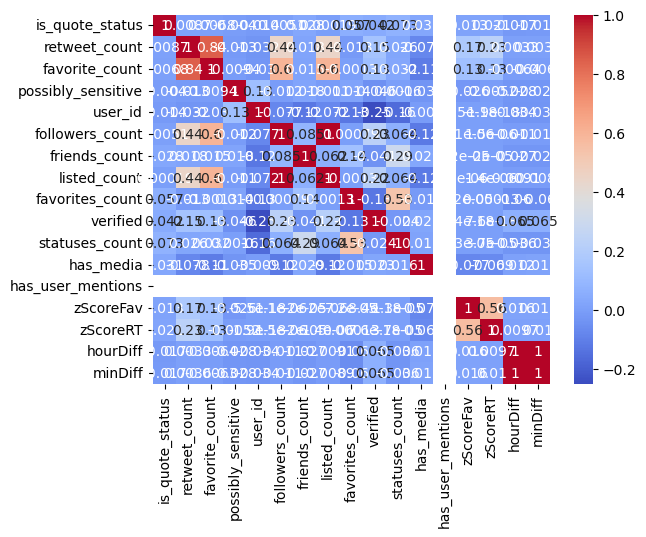

In [24]:
corr= df1.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)

It looks like followers_count and listed_count are the same, so lets also remove the latter.

In [25]:
df1 = df1.drop(columns = ['listed_count'])

# Discretization

Discreteize nominal data of who is being tweeted at into simly if the tweet is in reply to someone.

In [26]:
df1['in_reply_to_screen_name'] =  (df1['in_reply_to_screen_name'].values == None)
# type(df1.iloc[1].in_reply_to_screen_name)

# Text Cleaning
We need to ensure each column is the correct data type

In [27]:
for col in df1.columns:
    print(col,type(df1.iloc[1][col]))

tweeted_at <class 'pandas._libs.tslibs.timestamps.Timestamp'>
text <class 'str'>
in_reply_to_screen_name <class 'numpy.bool_'>
is_quote_status <class 'numpy.bool_'>
retweet_count <class 'numpy.int64'>
favorite_count <class 'numpy.int64'>
possibly_sensitive <class 'numpy.float64'>
tweet_lang <class 'str'>
user_id <class 'numpy.int64'>
name <class 'str'>
screen_name <class 'str'>
location <class 'str'>
followers_count <class 'numpy.int64'>
friends_count <class 'numpy.int64'>
created_at <class 'str'>
favorites_count <class 'numpy.int64'>
verified <class 'numpy.bool_'>
statuses_count <class 'numpy.int64'>
has_media <class 'numpy.bool_'>
has_user_mentions <class 'numpy.bool_'>
timeSinceLastPost <class 'pandas._libs.tslibs.timedeltas.Timedelta'>
zScoreFav <class 'numpy.float64'>
zScoreRT <class 'numpy.float64'>
hourDiff <class 'numpy.float64'>
minDiff <class 'numpy.float64'>


In [28]:
df1.tweeted_at = pd.to_datetime(df1.tweeted_at)
df1.created_at = pd.to_datetime(df1.created_at)

## Remove outliers

In [29]:
# temp = df1[['retweet_count','favorite_count','followers_count','friends_count','favorites_count','statuses_count','hourDiff','minDiff']]
# df1 = df1[(np.abs(stats.zscore(temp)) < 3).all(axis=1)]

### Save Data as .csv

In [30]:
df1.to_csv('twitterData',index=False)